## IMportant Imports 

In [42]:
import numpy as np
import pandas as pd
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Dropout, Activation, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from skimage.io import imshow
from keras.models import model_from_json
import tensorflow as tf
from keras import backend as K

## Reading Mnst fashin Data

In [43]:
#Read CSV
csv = pd.read_csv('fashion-mnist_train.csv')
#Separate into matricies
X_train = csv.iloc[:,1:786].as_matrix()
Y_train = csv.iloc[:,0].as_matrix()

C:\Users\BaadRoR\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\BaadRoR\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [44]:
# reshaping image to 2D image
X_train_imgs = np.zeros([X_train.shape[0],28,28])
for i in range(X_train.shape[0]):
    img = X_train[i,:].reshape([28,28])/255.
    X_train_imgs[i] = img

In [ ]:
One Hot encoding for classes 

In [45]:
Y_train_oh = np.zeros([Y_train.shape[0],10])
for i in range(Y_train.shape[0]):
    oh = np.zeros([10])
    oh[int(Y_train[i])] = 1.
    Y_train_oh[i] = oh

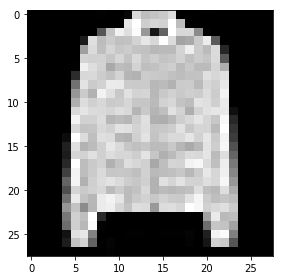

This is: Coat


In [15]:
ix = 12345 #0-41999
imshow(np.squeeze(X_train_imgs[ix]))
plt.show()
label = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print ('This is:',label[int(Y_train[ix])])

In [16]:
X_train_imgs.shape

(60000, 28, 28)

## Weight prune function

In [46]:
def weight_prune(weight, k):
    weight_temp = weight
    weight_temp = np.absolute(weight_temp)
    weight_temp = np.sort(weight_temp, axis = None)
    threshold = weight_temp[int(k*weight_temp.size)] #Finding the threshold weight
    weight[(weight < threshold) & (weight > -threshold)] = 0 #Setting the lowest k% weights to 0
    b = []
    b.append(weight)
    return b

## Unit prune function

In [47]:
def unit_prune(weight, k):
    weight_temp = np.linalg.norm(weight, axis=0) #Finding norm of each column
    sorted = np.sort(weight_temp)
    threshold = sorted[int(k*sorted.size)] #Finding threshold norm
    j=0
    for i in weight_temp:
        if(i<threshold):
            weight[:, j] = 0 #set jth column in weight matrix to 0 because it's norm is less than that of threshold
        j=j+1
    b = []
    b.append(weight)
    return b


Creating Neural Network with dense layers[1000,1000,500,200] and with the activation
function RELU and softmax probability function

In [48]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(1000, activation=tf.nn.relu, use_bias=False),
    Dense(1000, activation=tf.nn.relu, use_bias=False),
    Dense(500, activation=tf.nn.relu, use_bias=False),
  Dense(200, activation=tf.nn.relu, use_bias=False),
    Dense(10, activation=tf.nn.softmax, use_bias=False)
])
adam = Adam()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 1000)              784000    
_________________________________________________________________
dense_47 (Dense)             (None, 1000)              1000000   
_________________________________________________________________
dense_48 (Dense)             (None, 500)               500000    
_________________________________________________________________
dense_49 (Dense)             (None, 200)               100000    
_________________________________________________________________
dense_50 (Dense)             (None, 10)                2000      
Total params: 2,386,000
Trainable params: 2,386,000
Non-trainable params: 0
_________________________________________________________________


Training on the data and saving the trained model to load saved model to anytime

In [49]:
model.fit(X_train_imgs[:41000], Y_train_oh[:41000], epochs=10)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Epoch 1/10
41000/41000 [==============================] - 127s 3ms/step - loss: 0.5362 - acc: 0.8052
Epoch 2/10
41000/41000 [==============================] - 127s 3ms/step - loss: 0.4100 - acc: 0.8536
Epoch 3/10
41000/41000 [==============================] - 127s 3ms/step - loss: 0.3685 - acc: 0.8675
Epoch 4/10
41000/41000 [==============================] - 124s 3ms/step - loss: 0.3425 - acc: 0.8769
Epoch 5/10
41000/41000 [==============================] - 127s 3ms/step - loss: 0.3181 - acc: 0.8830
Epoch 6/10
41000/41000 [==============================] - 127s 3ms/step - loss: 0.3019 - acc: 0.8906 2s - loss:
Epoch 7/10
41000/41000 [==============================] - 129s 3ms/step - loss: 0.2907 - acc: 0.8940
Epoch 8/10
41000/41000 [==============================] - 133s 3ms/step - loss: 0.2768 - acc: 0.8970 5 - ETA: 2s - loss
Epoch 9/10
41000/41000 [==============================] - 151s 4ms/step - loss: 0.2693 - acc: 0.9013
Epoch 10/10
41000/41000 [==============================] - 16

18999/18999 [==============================] - 5s 261us/step


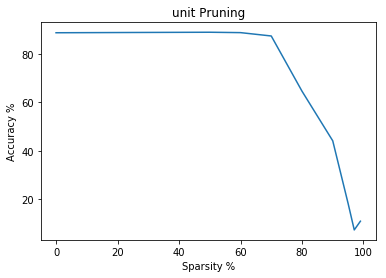

In [77]:
percentage = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
accuracy_1=[]
sparsity_1=[]
results1=[]
for k2 in percentage:
    model.load_weights("model.h5")
    k = k2*0.01
    for i in range(1,5):
        weight = model.layers[i].get_weights()[0]
        model.layers[i].set_weights(unit_prune(weight, k))
    score, acc = model.evaluate(X_train_imgs[41001:], Y_train_oh[41001:])
    results1.append("k = " + str(k) + " accuracy = " + str(acc))
    sparsity_1 .append(k*100)
    accuracy_1.append(acc*100)
plt.plot(sparsity_1,accuracy_1)
plt.xlabel('Sparsity %')
plt.ylabel('Accuracy %')
plt.title('unit Pruning')
plt.show()

In [83]:
results1

['k = 0.0 accuracy = 0.8886257171681056',
 'k = 0.25 accuracy = 0.8897310385008073',
 'k = 0.5 accuracy = 0.8907310911351565',
 'k = 0.6 accuracy = 0.8891520606598683',
 'k = 0.7000000000000001 accuracy = 0.8752565924647834',
 'k = 0.8 accuracy = 0.646770882656075',
 'k = 0.9 accuracy = 0.44128638349073085',
 'k = 0.9500000000000001 accuracy = 0.18190431075319755',
 'k = 0.97 accuracy = 0.07242486446753127',
 'k = 0.99 accuracy = 0.10847939364916023']

18999/18999 [==============================] - 5s 265us/step


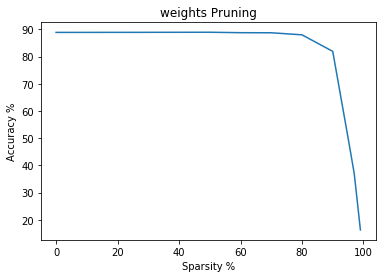

In [74]:
percentage = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
accuracy_=[]
sparsity_=[]
results=[]
for k2 in percentage:
    k = k2*0.01
    model.load_weights("model.h5")
    for i in range(1,5):
        weight = model.layers[i].get_weights()[0]
        model.layers[i].set_weights(weight_prune(weight, k))
    score, acc = model.evaluate(X_train_imgs[41001:], Y_train_oh[41001:])
    results.append("k = " + str(k) + " accuracy = " + str(acc))
    sparsity_.append(k*100)
    accuracy_.append(acc*100)
plt.plot(sparsity_,accuracy_)
plt.xlabel('Sparsity %')
plt.ylabel('Accuracy %')
plt.title('weights Pruning')
plt.show()

In [75]:
results

['k = 0.0 accuracy = 0.8886257171681056',
 'k = 0.25 accuracy = 0.8888888889139869',
 'k = 0.5 accuracy = 0.8892573293582208',
 'k = 0.6 accuracy = 0.8876256645212074',
 'k = 0.7000000000000001 accuracy = 0.8873098584261497',
 'k = 0.8 accuracy = 0.8797831464813938',
 'k = 0.9 accuracy = 0.8189904731953481',
 'k = 0.9500000000000001 accuracy = 0.5001842202503523',
 'k = 0.97 accuracy = 0.36928259384896267',
 'k = 0.99 accuracy = 0.16264013896252497']